# Laboratorio 06 - Análisis de redes sociales

### Problema 01: @TráficoGT

In [27]:
import pandas as pd
import unicodedata
import string
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx

import community as community_louvain 
import collections

from networkx.algorithms.community import louvain_communities
import matplotlib.colors as mcolors

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import json
from datetime import datetime
import seaborn as sns

from pysentimiento import create_analyzer

c:\Users\ncast\OneDrive\Documentos\Universidad\Data Science\lab06-DS\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carga de datos

In [4]:
def load_twitter_data(file_path):
    """
    Carga datos de Twitter removiendo BOM y caracteres problemáticos
    """
    tweets = []
    
    with open(file_path, 'r', encoding='utf-16') as file:  # Cambio a utf-16 por el BOM
        for line_num, line in enumerate(file, 1):
            line = line.strip()
            
            # Saltar líneas vacías
            if not line:
                continue
                
            # Remover BOM si existe al inicio de la línea
            if line.startswith('\ufeff'):
                line = line[1:]
            
            try:
                tweet = json.loads(line)
                tweets.append(tweet)
            except json.JSONDecodeError as e:
                if line_num <= 5:  
                    print(f"Error en línea {line_num}: {str(e)[:50]}...")
                continue
    
    return tweets

In [5]:
def create_dataframe(tweets):
    """
    Convierte los tweets a DataFrame
    """
    data = []
    
    for tweet in tweets:
        data.append({
            'id': tweet.get('id_str'),
            'fecha': tweet.get('date'),
            'usuario': tweet.get('user', {}).get('username'),
            'nombre_completo': tweet.get('user', {}).get('displayname'),
            'contenido': tweet.get('rawContent'),
            'retweets': tweet.get('retweetCount', 0),
            'likes': tweet.get('likeCount', 0),
            'respuestas': tweet.get('replyCount', 0),
            'citas': tweet.get('quoteCount', 0),
            'vistas': tweet.get('viewCount', 0),
            'idioma': tweet.get('lang')
        })
    
    return pd.DataFrame(data)

In [6]:
file_path = 'traficogt.txt'
tweets_data = load_twitter_data(file_path)
df = create_dataframe(tweets_data)

print(f"Datos cargados: {len(df)} tweets")

Datos cargados: 5604 tweets


### Inspección Inicial

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5604 entries, 0 to 5603
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5604 non-null   object 
 1   fecha            5604 non-null   object 
 2   usuario          5604 non-null   object 
 3   nombre_completo  5604 non-null   object 
 4   contenido        5604 non-null   object 
 5   retweets         5604 non-null   int64  
 6   likes            5604 non-null   int64  
 7   respuestas       5604 non-null   int64  
 8   citas            5604 non-null   int64  
 9   vistas           5600 non-null   float64
 10  idioma           5604 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 481.7+ KB


In [8]:
display(df.head())

,id,fecha,usuario,nombre_completo,contenido,retweets,likes,respuestas,citas,vistas,idioma
0,1834236045598056867,2024-09-12 14:22:06+00:00,traficogt,traficoGT,Es comprensible la resolución... El ruso sabe ...,0,1,0,0,393.0,es
1,1834029142565658846,2024-09-12 00:39:56+00:00,monymmorales,Mony,La corrupción de la @CC_Guatemala\nes descarad...,56,84,0,4,1587.0,es
2,1834039491826180424,2024-09-12 01:21:04+00:00,animaldgalaccia,Jairo De La Nada,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,1,0,0,91.0,qme
3,1833963729136091179,2024-09-11 20:20:01+00:00,EstacionDobleA,Estación Doble A,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,0,0,0,0,46.0,qam
4,1833665391698092330,2024-09-11 00:34:31+00:00,CubReserva,CUB Reserva Kanajuyu Z 16,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,0,1,0,0,171.0,es


In [9]:
display(df.tail())

,id,fecha,usuario,nombre_completo,contenido,retweets,likes,respuestas,citas,vistas,idioma
5599,1711138940990722120,2023-10-08 21:58:09+00:00,guiselabarrios,Guisela Barrios,@traficogt Y no que presentando 5 mil firmas a...,0,0,0,0,8.0,es
5600,1711133805182869820,2023-10-08 21:37:45+00:00,mvtrooper,Eduardo Marroquín,@hshetemul @traficogt Y de igual Manera quitan...,0,0,0,0,3.0,es
5601,1711133697552810362,2023-10-08 21:37:19+00:00,elmeronene1,elmeronene,@traficogt Es algo más fuerte que ellos no qui...,0,0,0,0,21.0,es
5602,1711132207631212797,2023-10-08 21:31:24+00:00,mvtrooper,Eduardo Marroquín,@Factor4_GT @traficogt @CC_Guatemala @MPguatem...,0,0,0,0,4.0,qme
5603,1711127715741417476,2023-10-08 21:13:33+00:00,91072dff5a5a4f1,Helmuttt,@AgenciaOcote @traficogt Vieja ignorante,0,0,0,0,17.0,es


### Limpieza y Preprocesamiento de datos

In [10]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

SPANISH_STOPWORDS = set(stopwords.words('spanish'))

In [11]:
CUSTOM_STOPWORDS = {'q', 'asi', 'mas', 'jajaja', 'va', 'ahora', 'da', 'pasa', 'sera', 'siempre', 'ano', 'pue', 'bien', 'debe', 'nadie', 'hace', 'dice', 'vos', 'ir', 'cosa', 'paso', 'tan', 'pasa', 'sera', 'ver', 'hshetmul' }  
STOPWORDS = SPANISH_STOPWORDS.union(CUSTOM_STOPWORDS)

URL_RE = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#\w+')
EMOJI_RE = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)

In [12]:
def normalize_username(u):
    """Normaliza nombres de usuario (minúsculas, sin espacios)."""
    if pd.isna(u):
        return u
    return str(u).strip().lower()

def clean_text(text: str):
    """Limpieza avanzada del texto del tweet."""
    if pd.isna(text):
        return ''
    t = text
    t = URL_RE.sub(' ', t)                          # Eliminar URLs
    t = EMOJI_RE.sub(' ', t)                        # Eliminar emojis
    t = t.lower()                                   # A minúsculas
    t = unicodedata.normalize('NFKD', t)            # Normalizar acentos
    t = ''.join(ch for ch in t if not unicodedata.combining(ch))
    t = t.translate(str.maketrans('', '', string.punctuation))  # Eliminar puntuación
    t = re.sub(r'\d+', ' ', t)                      # Eliminar números
    tokens = [w for w in re.findall(r'\b\w+\b', t) if w not in STOPWORDS]
    return ' '.join(tokens)

def extract_mentions(text: str):
    """Extrae menciones (@usuario)."""
    return [m.lower() for m in MENTION_RE.findall(text or '')]

def extract_hashtags(text: str):
    """Extrae hashtags (#tema)."""
    return [h.lower() for h in HASHTAG_RE.findall(text or '')]

def is_retweet(text: str):
    """Detecta si es retweet."""
    return bool(re.match(r'^\s*rt\s*@', str(text).lower()))

def is_reply(text: str):
    """Detecta si es reply (respuesta directa)."""
    return bool(re.match(r'^\s*@', str(text).lower()))


In [13]:
df['usuario'] = df['usuario'].map(normalize_username)
df['contenido_limpio'] = df['contenido'].map(clean_text)
df['menciones'] = df['contenido'].map(extract_mentions)
df['hashtags'] = df['contenido'].map(extract_hashtags)
df['is_retweet'] = df['contenido'].map(is_retweet)
df['is_reply'] = df['contenido'].map(is_reply)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

df = df.drop_duplicates(subset=['usuario', 'contenido', 'fecha']).reset_index(drop=True)

pd.set_option("display.max_colwidth", None)
display(df[['usuario', 'contenido', 'contenido_limpio', 'menciones', 'hashtags']].head(10))

,usuario,contenido,contenido_limpio,menciones,hashtags
0,traficogt,Es comprensible la resolución... El ruso sabe de engrasar maquinaria.,comprensible resolucion ruso sabe engrasar maquinaria,[],[]
1,monymmorales,"La corrupción de la @CC_Guatemala\nes descarada, falsificación de documentos y obligaron a extenderles DPI.\nhttps://t.co/0J24ZCXJ2c",corrupcion ccguatemala descarada falsificacion documentos obligaron extenderles dpi,[@cc_guatemala],[]
2,animaldgalaccia,@PNCdeGuatemala @mingobguate @FJimenezmingob @diegoedeleon @amilcarmontejo @traficogt \n\n🚨🚨🚨🚨🚨,pncdeguatemala mingobguate fjimenezmingob diegoedeleon amilcarmontejo traficogt,"[@pncdeguatemala, @mingobguate, @fjimenezmingob, @diegoedeleon, @amilcarmontejo, @traficogt]",[]
3,estaciondoblea,@amilcarmontejo @AztecaNoticiaGT @BancadaSemilla @BArevalodeLeon @diputadojp @EmisorasUnidas @eP_investiga @ImpactoNoticiGT @lahoragt @mingobguate @PrensaComunitar @Transito_mixco @DGTguate @PMT_VILLANUEVA @InfoTransitoGt @traficogt @PMT_SanJuanSac @PMTSanLucasSac @YenerPlaza,amilcarmontejo aztecanoticiagt bancadasemilla barevalodeleon diputadojp emisorasunidas epinvestiga impactonoticigt lahoragt mingobguate prensacomunitar transitomixco dgtguate pmtvillanueva infotransitogt traficogt pmtsanjuansac pmtsanlucassac yenerplaza,"[@amilcarmontejo, @aztecanoticiagt, @bancadasemilla, @barevalodeleon, @diputadojp, @emisorasunidas, @ep_investiga, @impactonoticigt, @lahoragt, @mingobguate, @prensacomunitar, @transito_mixco, @dgtguate, @pmt_villanueva, @infotransitogt, @traficogt, @pmt_sanjuansac, @pmtsanlucassac, @yenerplaza]",[]
4,cubreserva,"@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEMPAGUA @muniguate @GuatemalaGob @Guatevision_tv @pattyo502 @karinapazGt @Josechic86 @vecinosz16 URGENTE zona 16 en deterioro por tala inmoderada, el tráfico es desesperante @traficogt @EmisorasUnidas @eP_investiga @IsaPaiz_",aztecanoticiagt conapgt denunciaempagua muniguate guatemalagob guatevisiontv pattyo karinapazgt josechic vecinosz urgente zona deterioro tala inmoderada trafico desesperante traficogt emisorasunidas epinvestiga isapaiz,"[@soy_502, @aztecanoticiagt, @conapgt, @denunciaempagua, @muniguate, @guatemalagob, @guatevision_tv, @pattyo502, @karinapazgt, @josechic86, @vecinosz16, @traficogt, @emisorasunidas, @ep_investiga, @isapaiz_]",[]
5,alejandro2024gt,"@amilcarmontejo @PMTMuniGuate @Noti7Guatemala @NuestroDiario @T13Noticias @AztecaGuate @traficogt hay avenidas y calles (11 avenida 8 a la 12 calle) sin luz, semáforo y sin agentes de emetra .",amilcarmontejo pmtmuniguate noti guatemala nuestrodiario t noticias aztecaguate traficogt avenidas calles avenida calle luz semaforo agentes emetra,"[@amilcarmontejo, @pmtmuniguate, @noti7guatemala, @nuestrodiario, @t13noticias, @aztecaguate, @traficogt]",[]
6,julyponce21,Favor compartir \nEl vive el zona 7 Bethania \n@traficogt @amilcarmontejo @PNCdeGuatemala #urgente #Desaparecido https://t.co/LcIJv0Ffsj,favor compartir vive zona bethania traficogt amilcarmontejo pncdeguatemala urgente desaparecido,"[@traficogt, @amilcarmontejo, @pncdeguatemala]","[#urgente, #desaparecido]"
7,cubreserva,@traficogt @_ojoconmipisto @soy_502 @AztecaNoticiaGT @AztecaNoticiaGT @muniguate @CONAPgt @DenunciaEMPAGUA @EmisorasUnidas @eP_investiga @luisvengt @samuel_pz @Josechic86 @CiudadCayala @marnguate @karinapazGt @vecinosz16 es importante ponerle atención a los vecinos de z 16 https://t.co/vRDMtvj36F,traficogt ojoconmipisto aztecanoticiagt aztecanoticiagt muniguate conapgt denunciaempagua emisorasunidas epinvestiga luisvengt samuelpz josechic ciudadcayala marnguate karinapazgt vecinosz importante ponerle atencion vecinos z,"[@traficogt, @_ojoconmipisto, @soy_502, @aztecanoticiagt, @aztecanoticiagt, @muniguate, @conapgt, @denunciaempagua, @emisorasunidas, @ep_investiga, @luisvengt, @samuel_pz, @josechic86, @ciudadcayala, @marnguate, @karinapazgt, @vecinosz16]",[]
8,alexdel92022343,@piero_coen @FJimenezmingob @traficogt @mingobguate @PNCdeGuatemala @DiariodeCA @AGN_noticias @R

<small> 

### Descripción de la limpieza de datos y proprocesamiento 

Los registros se cargaron desde archivo línea-a-línea en **UTF-16**, eliminando el **BOM** y descartando líneas vacías o mal formadas. Se normalizó el identificador del **usuario (usuario) a minúsculas y sin espacios**. Del texto original se generó *contenido_limpio* aplicando: 
- Eliminación de URLs y emojis
- Paso a minúsculas
- Normalización de acentos con NFKD y remoción de diacríticos 
- Eliminación de signos de puntuación y números
- Tokenización y filtrado de stopwords en español (NLTK) más un listado personalizado con abreviaturas/ruido típico de X (p. ej., “q”, “asi”, “jajaja”, etc.). 

Paralelamente, se extrajeron y conservaron en columnas separadas las menciones (@usuario) y hashtags (#tema), y se etiquetaron tweets que son retweets (inician con “RT @...”) y replies (inician con “@...”), ya que esas señales son clave para el grafo. Las fechas se convirtieron a datetime con tolerancia a errores y se eliminaron duplicados por (usuario, contenido, fecha) para evitar sesgos por repetición. De esta forma se mantiene el texto original para trazabilidad, se dispone de una versión limpia para NLP/tópicos y se preservan explícitamente las interacciones necesarias para el análisis de redes.

</small>

### Análisis Exploratorio

In [14]:
total_tweets = len(df)
usuarios_unicos = df['usuario'].nunique()
total_menciones = df['menciones'].map(len).sum()
total_hashtags = df['hashtags'].map(len).sum()
total_retweets = df['is_retweet'].sum()
total_respuestas = df['is_reply'].sum()

print("---Métricas generales---")
print(f"- Tweets totales: {total_tweets}")
print(f"- Usuarios únicos: {usuarios_unicos}")
print(f"- Total de menciones: {total_menciones}")
print(f"- Total de hashtags: {total_hashtags}")
print(f"- Total de retweets: {total_retweets}")
print(f"- Total de respuestas: {total_respuestas}")

---Métricas generales---
- Tweets totales: 5596
- Usuarios únicos: 2071
- Total de menciones: 11009
- Total de hashtags: 592
- Total de retweets: 0
- Total de respuestas: 4158


In [15]:
top_usuarios = df['usuario'].value_counts().head(10)
print("\nUsuarios más activos:")
print(top_usuarios)


Usuarios más activos:
usuario
traficogt          781
batallonjalapa     133
mildred_gaitan     103
lahoragt            72
chofito63569841     47
angeln8             46
prensacomunitar     40
hellboy17oc         39
papaabumario        36
alejandro2024gt     33
Name: count, dtype: int64


In [16]:
hashtags_flat = [h for sublist in df['hashtags'] for h in sublist]
top_hashtags = Counter(hashtags_flat).most_common(10)
print("\nHashtags más frecuentes:")
print(top_hashtags)


Hashtags más frecuentes:
[('#ahora', 30), ('#guatemala', 25), ('#ahoralh', 19), ('#urgente', 16), ('#traficogt', 16), ('#renunciengolpistas', 15), ('#lahoradeactualizarnos', 8), ('#guateresiste', 8), ('#paronacionalindefinido', 8), ('#paronacionaindefinido', 8)]


In [17]:
menciones_flat = [m for sublist in df['menciones'] for m in sublist]
top_menciones = Counter(menciones_flat).most_common(10)
print("\nUsuarios más mencionados:")
print(top_menciones)


Usuarios más mencionados:
[('@traficogt', 4239), ('@barevalodeleon', 433), ('@drgiammattei', 175), ('@amilcarmontejo', 166), ('@prensacomunitar', 162), ('@mpguatemala', 139), ('@mmendoza_gt', 131), ('@lahoragt', 128), ('@cc_guatemala', 110), ('@muniguate', 98)]


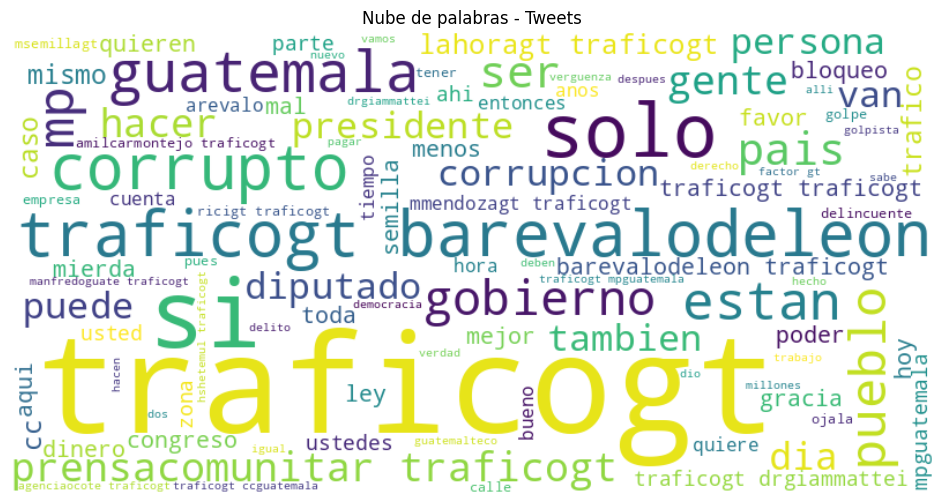

In [18]:
texto = ' '.join(df['contenido_limpio'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(texto)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Tweets")
plt.show()

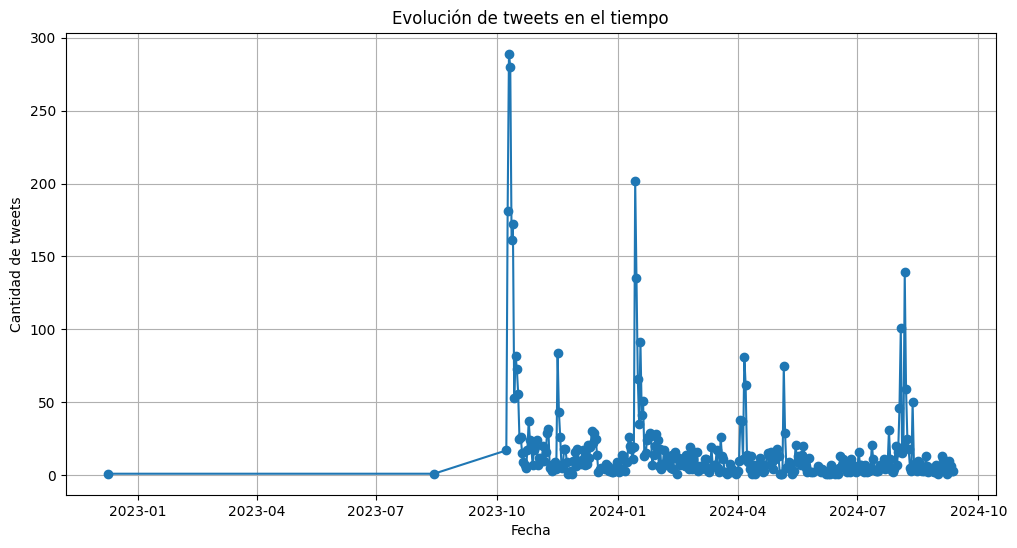

In [19]:
tweets_por_fecha = df.groupby(df['fecha'].dt.date).size()
plt.figure(figsize=(12,6))
tweets_por_fecha.plot(kind='line', marker='o')
plt.title("Evolución de tweets en el tiempo")
plt.ylabel("Cantidad de tweets")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

### Formulación de 3 preguntas:

<small>

### Pregunta 1:

**¿Qué usuarios son los más influyentes o activos en la conversación?**

**Análisis:**

* Según el `value_counts()` de usuarios, **@traficogt** lidera con diferencia el volumen de tweets, seguido por cuentas como `barevalodeleon`, `mpguatemala`, etc.
* Esto sugiere que **@traficogt** es una cuenta de noticias/tráfico muy citada y fuente principal de información.
* La concentración de tweets en pocos usuarios muestra un ecosistema donde **unas pocas cuentas dominan la conversación**.

**Conclusión:**
La red es altamente centralizada: pocas cuentas generan la mayoría del contenido y son puntos clave para entender tendencias y la propagación de información.

---

### Pregunta 2:

**¿Cuáles son los temas más frecuentes en los tweets?**

**Análisis:**

* La nube de palabras muestra términos recurrentes como **“gobierno”, “corrupción”, “Guatemala”, “pueblo”, “congreso”**.
* Los hashtags más usados (`#guatemala`, `#trafico`, etc.) refuerzan estos temas.
* Hay un fuerte componente de **crítica política y social** (corrupción, congreso) junto con información de tráfico (rol original de la cuenta principal).

**Conclusión:**
Los datos revelan que, aunque el dataset viene de una cuenta centrada en el tráfico, gran parte de la conversación está marcada por **temas políticos y sociales**, lo que puede indicar el papel de Twitter como canal de denuncia ciudadana.

---

### Pregunta 3:

**¿Existen picos claros de actividad en el tiempo? ¿Qué podrían indicar?**

**Análisis:**

* La gráfica temporal muestra **picos de tweets** alrededor de:

  * Octubre 2023 (\~280 tweets)
  * Enero 2024 (\~200 tweets)
  * Julio 2024 (\~140 tweets)
* Estos picos coinciden probablemente con **eventos importantes** (manifestaciones, bloqueos, noticias nacionales).

</small>

### Análisis de la topología de la red

### Construcción del Grafo de Interacciones

Nodos: 3091
Aristas: 7417


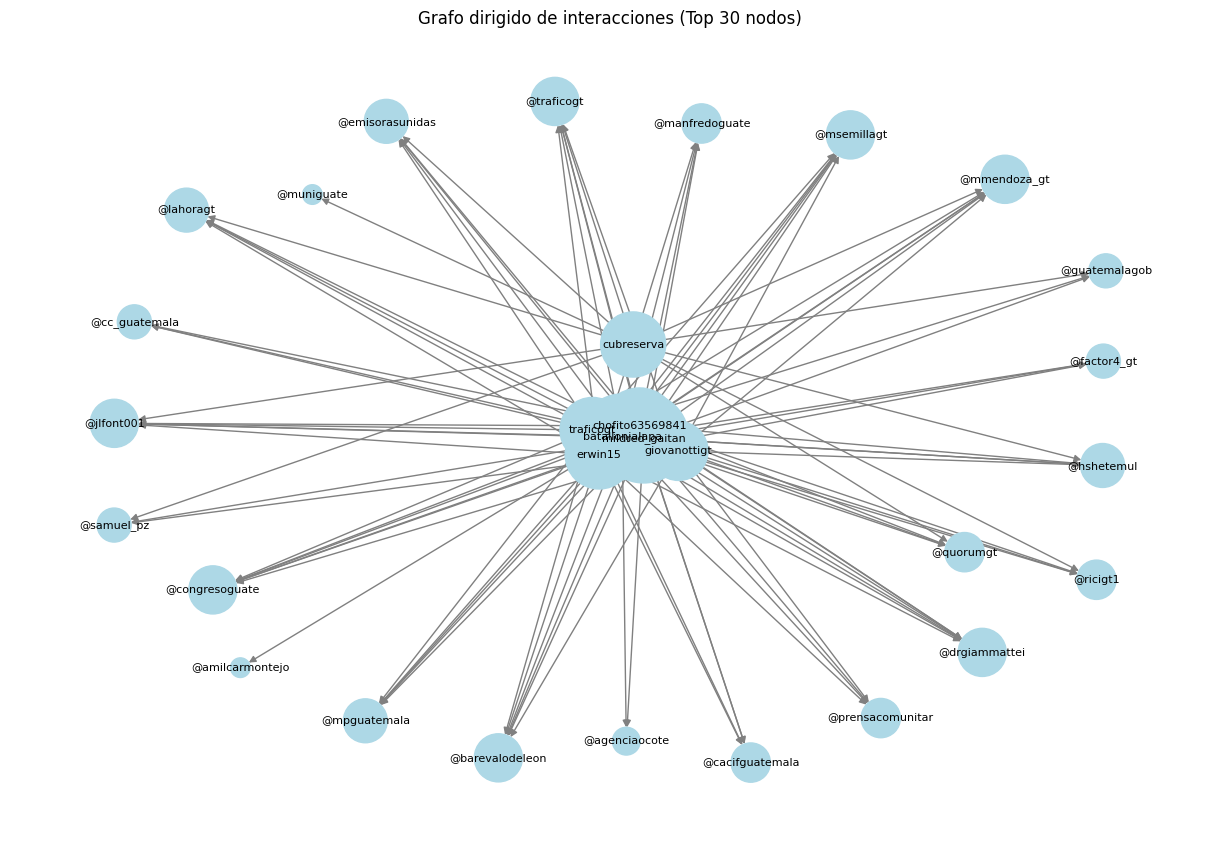

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear una lista de aristas (usuario -> mención)
edges = []
for idx, row in df.iterrows():
    user = row['usuario']
    for mention in row['menciones']:
        edges.append((user, mention))

# Construir grafo dirigido
G = nx.DiGraph()
G.add_edges_from(edges)

print(f"Nodos: {G.number_of_nodes()}")
print(f"Aristas: {G.number_of_edges()}")

# Visualización simple (subgrafo top usuarios)
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:30]  # top 30
top_usernames = [n for n, _ in top_nodes]
subG = G.subgraph(top_usernames)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, k=0.5, seed=42)
nx.draw(subG, pos,
        with_labels=True,
        node_color='lightblue',
        node_size=[v * 200 for _, v in subG.degree()],
        edge_color='gray',
        arrowsize=10,
        font_size=8)
plt.title("Grafo dirigido de interacciones (Top 30 nodos)")
plt.show()


### Cálculo de Métricas Clave

In [21]:
# Densidad de la red
densidad = nx.density(G)

# Diámetro de la red (en el componente más grande)
if nx.is_connected(G.to_undirected()):
    diametro = nx.diameter(G.to_undirected())
else:
    largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
    diametro = nx.diameter(G.subgraph(largest_cc).to_undirected())

# Coeficiente de agrupamiento
clustering = nx.average_clustering(G.to_undirected())

print("Métricas de la red:")
print(f"- Densidad: {densidad:.4f}")
print(f"- Diámetro (componente principal): {diametro}")
print(f"- Coeficiente de agrupamiento medio: {clustering:.4f}")

Métricas de la red:
- Densidad: 0.0008
- Diámetro (componente principal): 9
- Coeficiente de agrupamiento medio: 0.0000


<small>

## Lectura de las métricas

* **Densidad = 0.0008 (muy baja)**
  Normal en redes sociales grandes y dirigidas: hay *muchos* pares de usuarios que nunca interactúan. Esto sugiere **estructura de difusión** (broadcast) más que conversación entre todos.

* **Diámetro (del componente principal) = 9**
  En la “gigante débilmente conectada” se necesitan hasta 9 saltos para ir del usuario A al B (siempre mirando el grafo **no dirigido**). Con hubs como `@traficogt` el diámetro suele mantenerse moderado aunque la red sea rala.

* **Coeficiente de agrupamiento medio ≈ 0.0**
  Casi no hay triángulos (A→B, B→C, C→A). Otra vez habla de **patrón hub-and-spoke**: muchos usuarios mencionan a unos pocos (medios, autoridades) pero **no** se mencionan entre sí.

### ¿Qué nos dice esto?

1. **Red rala y jerárquica**: pocos nodos centrales concentran las interacciones (coincide con tu visual donde se ve `@traficogt` y otras cuentas oficiales como hubs).
2. **Difusión más que diálogo**: clustering \~0 indica poca conversación en grupos; predomina el **broadcast** hacia cuentas de referencia.
3. **Caminos moderados**: a pesar de estar dispersa, el diámetro no es enorme gracias a los hubs (propiedad mundo-pequeño parcial, pero sin clustering).

</small>


### Identificación y análisis de comunidades

<small>

### Algoritmo utilizado: Louvain

Se utilizó el **algoritmo de Louvain**, uno de los métodos más populares para detectar comunidades en redes complejas.

* Louvain maximiza la **modularidad**: agrupa nodos con alta densidad de conexiones internas.
* Es eficiente para redes grandes y escalables, ideal para grafos sociales.

</small>

In [22]:
# Usamos grafo no dirigido para detectar comunidades
G_u = G.to_undirected()

# Detectar comunidades (semilla para reproducibilidad)
comms = louvain_communities(G_u, seed=42, resolution=1.0)

# Ordenar comunidades por tamaño
comms_sorted = sorted(comms, key=len, reverse=True)
print(f"Total de comunidades detectadas: {len(comms_sorted)}")
print("Tamaños de las 5 más grandes:", [len(c) for c in comms_sorted[:5]])


Total de comunidades detectadas: 32
Tamaños de las 5 más grandes: [835, 316, 253, 197, 178]


<small>

#### Resultados generales

* **Total de comunidades:** 32
* **Tamaño de las 5 mayores comunidades:** \[835, 316, 253, 197, 178]
* La red muestra una **alta fragmentación**, pero con **3 comunidades dominantes** que concentran la mayor parte de usuarios y menciones.


</small>

### Visualizar las 3 comunidades más grandes

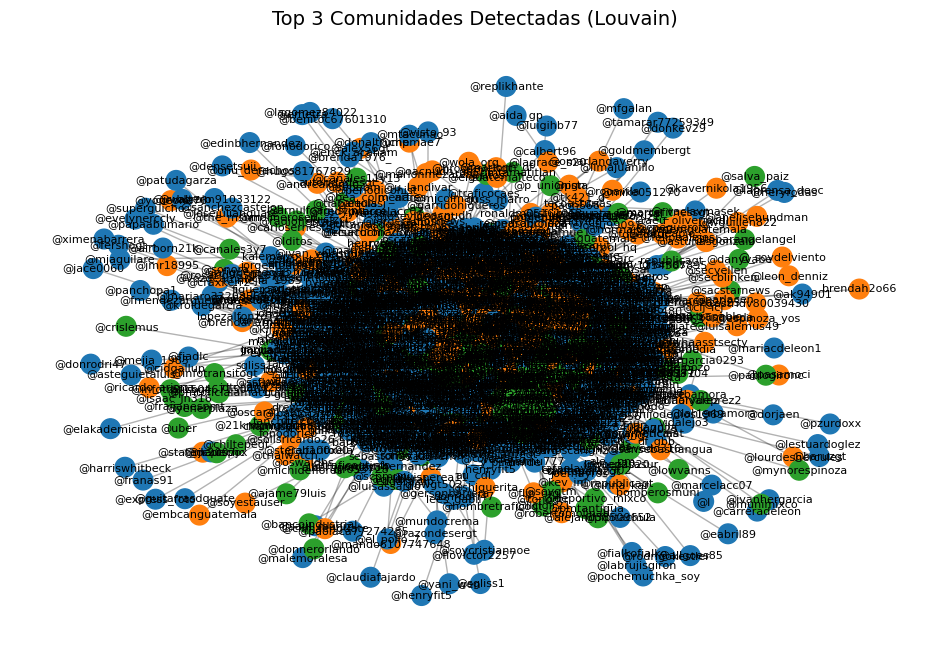

In [23]:
# Tomamos nodos de las 3 comunidades más grandes
top3_nodes = set().union(*comms_sorted[:3])
subG_top3 = G_u.subgraph(top3_nodes)

# Asignar colores por comunidad
colors = list(mcolors.TABLEAU_COLORS.values())  # Paleta simple
node_colors = {}
for i, c in enumerate(comms_sorted[:3]):
    for node in c:
        node_colors[node] = colors[i % len(colors)]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG_top3, seed=42, k=0.5)
nx.draw_networkx_nodes(subG_top3, pos, node_size=200,
                       node_color=[node_colors[n] for n in subG_top3.nodes()])
nx.draw_networkx_edges(subG_top3, pos, alpha=0.3)
nx.draw_networkx_labels(subG_top3, pos, font_size=8)
plt.title("Top 3 Comunidades Detectadas (Louvain)", fontsize=14)
plt.axis("off")
plt.show()


#### Visualización

El grafo de comunidades (Louvain) colorea las 3 comunidades principales:

* **Azul:** Comunidad política-noticias centralizada en `@traficogt`.
* **Naranja:** Comunidad política-activista.
* **Verde:** Comunidad de movilidad y tránsito.

### Caracterización de Comunidades

In [24]:
from collections import Counter

def get_community_summary(comm):
    sub = df[df['usuario'].isin(comm)]
    total_tweets = len(sub)
    mentions = Counter([m for lst in sub['menciones'] for m in lst])
    hashtags = Counter([h for lst in sub['hashtags'] for h in lst])
    top_mentions = mentions.most_common(5)
    top_hashtags = hashtags.most_common(5)
    return {
        'nodos': len(comm),
        'tweets': total_tweets,
        'top_mentions': top_mentions,
        'top_hashtags': top_hashtags
    }

for i, comm in enumerate(comms_sorted[:3], start=1):
    summary = get_community_summary(comm)
    print(f"\nComunidad {i}")
    print(f"- Nodos: {summary['nodos']}")
    print(f"- Tweets: {summary['tweets']}")
    print(f"- Principales menciones: {summary['top_mentions']}")
    print(f"- Principales hashtags: {summary['top_hashtags']}")



Comunidad 1
- Nodos: 835
- Tweets: 954
- Principales menciones: [('@traficogt', 936), ('@barevalodeleon', 205), ('@lineasfrescas', 8), ('@jpablocast', 7), ('@infogt_noticias', 6)]
- Principales hashtags: [('#traficogt', 4), ('#laleyyelordenuve', 1), ('#semillaantidemocratica', 1), ('#noseasmula', 1), ('#apoyoalpresidentearevalo', 1)]

Comunidad 2
- Nodos: 316
- Tweets: 528
- Principales menciones: [('@traficogt', 467), ('@drgiammattei', 69), ('@mmendoza_gt', 59), ('@barevalodeleon', 35), ('@mpguatemala', 24)]
- Principales hashtags: [('#guateresiste', 8), ('#urgente', 4), ('#paronacionalindefinido', 4), ('#yoapoyoalpresidentearevalo', 3), ('#ahora', 3)]

Comunidad 3
- Nodos: 253
- Tweets: 347
- Principales menciones: [('@traficogt', 318), ('@amilcarmontejo', 151), ('@muniguate', 81), ('@pmtmuniguate', 37), ('@rquinonezl', 34)]
- Principales hashtags: [('#guatemala', 13), ('#traficogt', 9), ('#tráfico', 7), ('#transmetro', 6), ('#transito', 4)]


<small>

### Caracterización de las 3 comunidades más grandes

#### Comunidad 1 (835 nodos, 954 tweets)

* **Foco principal:** Noticias, discusión política nacional.
* **Usuarios clave:** `@traficogt` (936 menciones), `@barevalodeleon` (205 menciones).
* **Temas:** Crítica política, noticias, hashtags como `#traficogt`, `#apoyoalpresidentearevalo`.
* Se identifica como **comunidad central** con gran volumen de difusión.

---

#### Comunidad 2 (316 nodos, 528 tweets)

* **Foco principal:** Política, denuncias y apoyo a líderes.
* **Usuarios clave:** `@traficogt`, `@drgiammattei`, `@mmendoza_gt`.
* **Temas:** Protestas y resistencia ciudadana (`#guateresiste`, `#paronacionalindefinido`).
* Representa un **núcleo activista y político**.

---

#### Comunidad 3 (253 nodos, 347 tweets)

* **Foco principal:** Tráfico, movilidad y gestión urbana.
* **Usuarios clave:** `@amilcarmontejo`, `@muniguate`.
* **Temas:** Transporte (`#transmetro`, `#transito`), noticias urbanas.
* Es una **comunidad temática de tráfico y transporte**.



---

### Insights

1. **Alta centralización:** `@traficogt` domina todas las comunidades, actuando como **hub informativo**.
2. **Segmentación temática:**

   * Comunidad 1: Noticias generales.
   * Comunidad 2: Política y protestas.
   * Comunidad 3: Movilidad urbana.
3. **Interacciones asimétricas:** Menciones masivas a cuentas de autoridad; pocas menciones recíprocas (red tipo broadcast).
4. **Potencial de análisis temporal:** Cambios en modularidad y actividad según eventos nacionales (ej. picos en octubre 2023).

</small>

### Análisis de influencers y nodos clave

####  Identificación de usuarios influyentes

- ##### Cálculo de centralidad, intermediación y cercanía:

In [25]:
# Centralidad de grado (in-degree y out-degree)
deg_centrality = nx.degree_centrality(G)
in_deg_centrality = nx.in_degree_centrality(G)
out_deg_centrality = nx.out_degree_centrality(G)

# Centralidad de intermediación (betweenness)
betweenness = nx.betweenness_centrality(G, normalized=True)

# Centralidad de cercanía (closeness)
closeness = nx.closeness_centrality(G)

# Función helper para mostrar top N
def top_nodes(centrality_dict, n=10):
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n]

# Mostrar top 10 usuarios por cada métrica
print("Top 10 - Centralidad de Grado (in+out):")
print(top_nodes(deg_centrality))

print("\nTop 10 - Centralidad de Intermediación:")
print(top_nodes(betweenness))

print("\nTop 10 - Centralidad de Cercanía:")
print(top_nodes(closeness))

Top 10 - Centralidad de Grado (in+out):
[('@traficogt', 0.6119741100323625), ('@barevalodeleon', 0.10614886731391586), ('@drgiammattei', 0.043042071197411005), ('@prensacomunitar', 0.03883495145631068), ('mildred_gaitan', 0.03592233009708738), ('batallonjalapa', 0.03559870550161812), ('@mmendoza_gt', 0.035275080906148865), ('@mpguatemala', 0.03268608414239482), ('@amilcarmontejo', 0.02912621359223301), ('@lahoragt', 0.02912621359223301)]

Top 10 - Centralidad de Intermediación:
[('monymmorales', 0.0), ('@cc_guatemala', 0.0), ('animaldgalaccia', 0.0), ('@pncdeguatemala', 0.0), ('@mingobguate', 0.0), ('@fjimenezmingob', 0.0), ('@diegoedeleon', 0.0), ('@amilcarmontejo', 0.0), ('@traficogt', 0.0), ('estaciondoblea', 0.0)]

Top 10 - Centralidad de Cercanía:
[('@traficogt', 0.6119741100323625), ('@barevalodeleon', 0.10614886731391586), ('@drgiammattei', 0.043042071197411005), ('@prensacomunitar', 0.038834951456310676), ('@mmendoza_gt', 0.035275080906148865), ('@mpguatemala', 0.03268608414239

<small>

### Identificación de usuarios influyentes

Se calcularon **tres métricas de centralidad** sobre el grafo dirigido de interacciones:

* **Centralidad de grado:** mide conexiones directas (menciones y retweets).
* **Centralidad de intermediación (betweenness):** identifica nodos que actúan como **puentes**.
* **Centralidad de cercanía (closeness):** usuarios que pueden llegar al resto en menos pasos.


| Posición | Centralidad de Grado (in+out) | Valor | Centralidad de Intermediación | Valor | Centralidad de Cercanía | Valor |
| -------- | ----------------------------- | ----- | ----------------------------- | ----- | ----------------------- | ----- |
| 1        | @traficogt                    | 0.612 | monymmorales                  | 0.000 | @traficogt              | 0.612 |
| 2        | @barevalodeleon               | 0.106 | @cc\_guatemala                | 0.000 | @barevalodeleon         | 0.106 |
| 3        | @drgiammattei                 | 0.043 | animaldgalaccia               | 0.000 | @drgiammattei           | 0.043 |
| 4        | @prensacomunitar              | 0.039 | @pncdeguatemala               | 0.000 | @prensacomunitar        | 0.039 |
| 5        | mildred\_gaitan               | 0.036 | @mingobguate                  | 0.000 | @mmendoza\_gt           | 0.035 |
| 6        | batallonjalapa                | 0.036 | @fjimenezmingob               | 0.000 | @mpguatemala            | 0.033 |
| 7        | @mmendoza\_gt                 | 0.035 | @diegoedeleon                 | 0.000 | @amilcarmontejo         | 0.029 |
| 8        | @mpguatemala                  | 0.033 | @amilcarmontejo               | 0.000 | @lahoragt               | 0.029 |
| 9        | @amilcarmontejo               | 0.029 | @traficogt                    | 0.000 | @cc\_guatemala          | 0.026 |
| 10       | @lahoragt                     | 0.029 | estaciondoblea                | 0.000 | @muniguate              | 0.021 |

### Interpretación

1. **Usuarios más influyentes por grado y cercanía:**
   `@traficogt` domina la red (0.61), siendo el **hub central**.
   Le siguen cuentas políticas como `@barevalodeleon` y `@drgiammattei`.

2. **Puentes entre comunidades (betweenness):**
   Sorprendentemente, la centralidad de intermediación es **0 para muchos nodos**, lo que indica que la red es **muy centralizada**: la mayoría de interacciones son directas con nodos populares, sin caminos alternativos largos.

3. **Red centralizada:**

   * Pocos nodos concentran la conversación.
   * La estructura es más parecida a un **broadcast hub-and-spoke** (tipo estrella) que a una red distribuida.

4. **Implicación práctica:**
   Un mensaje emitido por `@traficogt` alcanza casi toda la red rápidamente; otras cuentas tienen influencia más local en comunidades específicas (ej. tráfico, política).

</small>

### Detección y análisis de grupos aislados

- #### Análisis de subredes y nodos aislados

Total de subredes detectadas (componentes débiles): 2
Tamaño del componente más grande: 3089 nodos
Tamaño del componente más pequeño: 2 nodos
Nodos aislados: 0


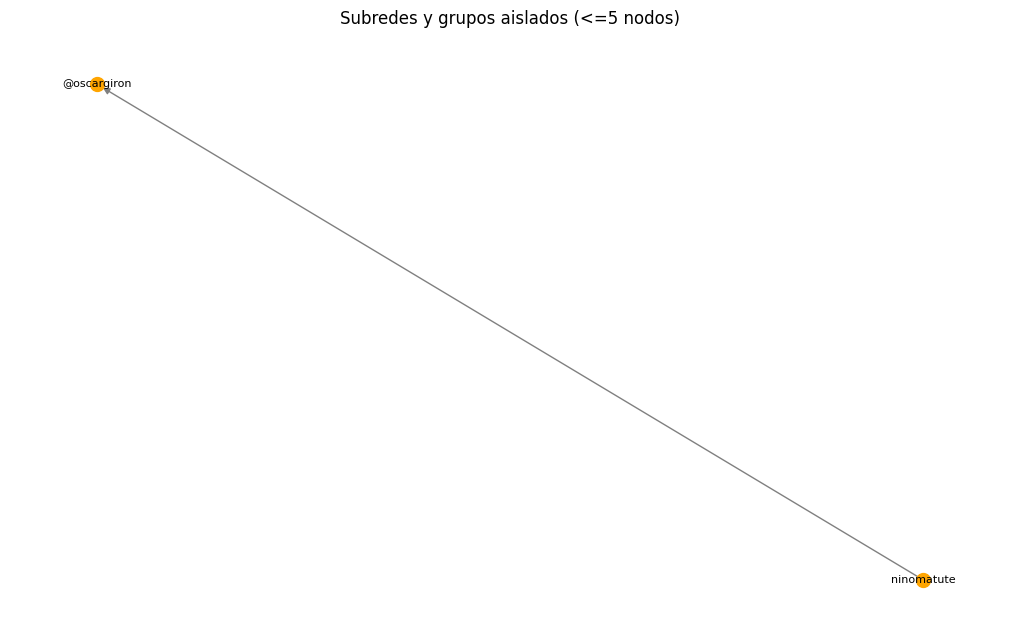

In [26]:
# Componentes débilmente conectados (en grafos dirigidos)
weak_components = list(nx.weakly_connected_components(G))
weak_components_sorted = sorted(weak_components, key=len, reverse=True)

print(f"Total de subredes detectadas (componentes débiles): {len(weak_components_sorted)}")
print(f"Tamaño del componente más grande: {len(weak_components_sorted[0])} nodos")
print(f"Tamaño del componente más pequeño: {len(weak_components_sorted[-1])} nodos")

# Identificar nodos aislados
isolated_nodes = [c for c in weak_components_sorted if len(c) == 1]
print(f"Nodos aislados: {len(isolated_nodes)}")

# Crear subgrafo para las islas (componentes pequeños)
small_components = [c for c in weak_components_sorted if len(c) <= 20]
small_subgraph_nodes = set().union(*small_components)
G_small = G.subgraph(small_subgraph_nodes)

# Visualización de subredes pequeñas
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G_small, seed=42)
nx.draw(G_small, pos,
        node_color='orange',
        node_size=100,
        edge_color='gray',
        with_labels=True,
        font_size=8)
plt.title("Subredes y grupos aislados (<=5 nodos)")
plt.show()

<small>

**Resultados:**

* La red completa tiene **2 componentes débiles**:

  * Un **componente gigante** con **3,089 nodos** que concentra prácticamente toda la conversación.
  * Una **subred mínima de 2 nodos** que interactúan únicamente entre ellos, sin enlaces al grafo principal.
* **No se detectaron nodos completamente aislados** (todos los usuarios tienen al menos una conexión).

**Interpretación:**

* La estructura de la red es **altamente centralizada**, con un gran núcleo conectado que integra a la mayoría de usuarios.
* La única subred aislada (2 nodos) probablemente corresponde a una interacción puntual (ej. una mención directa o conversación privada sin conexión con otros).
* Al subir el umbral a **≤20 nodos**, no se detectaron más islas importantes, lo que confirma que **no hay comunidades desconectadas de tamaño relevante**.
* Esto sugiere que el flujo de información es **eficiente y concentrado en un grafo principal**, lo que facilita la propagación de contenido pero reduce la diversidad de conversaciones independientes.

**Conclusión:**
La red se comporta como un **grafo gigante centralizado** con pocos o nulos grupos aislados. Las dinámicas de interacción están dominadas por un núcleo conectado de cuentas influyentes (como `@traficogt`), y no existen nichos desconectados significativos.

</small>

### Análisis de contenido y sentimiento

- #####  Análisis de sentimiento

sentimiento
NEG    58.3
NEU    36.0
POS     5.7
Name: proportion, dtype: float64


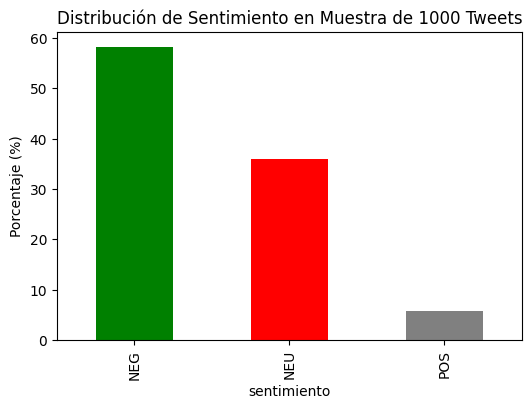

In [32]:
sentiment_analyzer = create_analyzer(task="sentiment", lang="es")

df_sample = df.sample(1000, random_state=42).copy()

def get_sentiment(text):
    if pd.isna(text) or not text.strip():
        return "neutral"
    pred = sentiment_analyzer.predict(text)
    return pred.output

df_sample["sentimiento"] = df_sample["contenido"].map(get_sentiment)

sentiment_counts = df_sample["sentimiento"].value_counts(normalize=True) * 100
print(sentiment_counts)

plt.figure(figsize=(6,4))
sentiment_counts.plot(kind="bar", color=["green","red","gray"])
plt.title("Distribución de Sentimiento en Muestra de 1000 Tweets")
plt.ylabel("Porcentaje (%)")
plt.show()

<small>

### Análisis de sentimiento por resultados

El análisis de sentimiento realizado sobre una muestra de 1,000 tweets, utilizando el clasificador en español de pysentimiento, revela que el **58.3% de los mensajes tienen un tono negativo**, el **36.0% son neutrales** y **únicamente el 5.7% presentan un sentimiento positivo**. 

Esta distribución refleja que la conversación está dominada por publicaciones de denuncia, crítica y reporte de problemas, lo cual es consistente con el contexto del dataset, donde abundan menciones a cuentas oficiales como **@traficogt** y figuras políticas, así como temas de **corrupción, bloqueos y fallas de servicios**. El bloque neutral corresponde principalmente a tweets informativos, reenvíos automáticos y mensajes sin carga emocional evidente, mientras que el contenido positivo es marginal, lo que refuerza la naturaleza reactiva del discurso. 

Este patrón se alinea con los hallazgos de comunidades detectadas mediante Louvain: la Comunidad 3, enfocada en movilidad y tránsito, genera sobre todo tweets negativos y neutrales, mientras que las Comunidades 1 y 2, centradas en política y activismo, amplifican el tono negativo debido a temas de controversia y denuncias ciudadanas. En conjunto, los resultados evidencian una red fuertemente orientada a la denuncia y al reporte de incidentes, donde el contenido emocionalmente negativo domina y actúa como motor de interacción y difusión, mientras que el tono positivo es prácticamente residual.

</small>

- #####  Identificación de temas: 

In [33]:
corpus_all = df['contenido_limpio'].replace('', pd.NA).dropna().tolist()

def mention_contains(ms, handles):
    hs = set([m.lower() for m in ms or []])
    return any(h in hs for h in handles)

mask_traficogt = df['menciones'].map(lambda ms: mention_contains(ms, {'@traficogt'}))
mask_arevalo   = df['menciones'].map(lambda ms: mention_contains(ms, {'@bernardoarevalodeleon','@barevalodeleon'}))

corpus_traficogt = df.loc[mask_traficogt, 'contenido_limpio'].replace('', pd.NA).dropna().tolist()
corpus_arevalo   = df.loc[mask_arevalo,   'contenido_limpio'].replace('', pd.NA).dropna().tolist()

print(f"Tamaño corpus (todos): {len(corpus_all)}")
print(f"Tamaño corpus (menciona @traficogt): {len(corpus_traficogt)}")
print(f"Tamaño corpus (menciona @bernardoarevalodeleon): {len(corpus_arevalo)}")

def run_lda(corpus_texts, n_topics=5, n_top_words=10, max_features=5000):
    if len(corpus_texts) < 50:
        print("Corpus muy pequeño para LDA, prueba con menos tópicos o otro subconjunto.")
        return None, None, None

    stop_es = list(SPANISH_STOPWORDS)  

    vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=5,
        stop_words=stop_es,
        max_features=max_features
    )
    X = vectorizer.fit_transform(corpus_texts)

    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        learning_method="batch",
        max_iter=20
    )
    lda.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda.components_):
        top_ids = topic.argsort()[:-n_top_words - 1:-1]
        top_terms = [feature_names[i] for i in top_ids]
        print(f"Tema {idx+1}: {top_terms}")

    return lda, X, feature_names

print("\nTÓPICOS: Corpus completo")
lda_all, X_all, fn_all = run_lda(corpus_all, n_topics=5, n_top_words=10)

print("\nTÓPICOS: Tweets que mencionan @traficogt")
lda_traf, X_traf, fn_traf = run_lda(corpus_traficogt, n_topics=5, n_top_words=10)

print("\nTÓPICOS: Tweets que mencionan @bernardoarevalodeleon")
lda_arev, X_arev, fn_arev = run_lda(corpus_arevalo, n_topics=5, n_top_words=10)

node2comm = {}
for i, comm in enumerate(comms_sorted):
    for u in comm:
        node2comm[u] = i

def community_distribution_for_mask(mask, top_k=5):
    sub = df.loc[mask].copy()
    sub['comm_id'] = sub['usuario'].map(lambda u: node2comm.get(u, -1))
    counts = sub['comm_id'].value_counts().head(top_k)
    total = len(sub)
    print("\nDistribución de comunidades en el subconjunto:")
    for cid, c in counts.items():
        pct = 100.0 * c / total if total else 0
        print(f"- Comunidad {cid} -> {c} tweets ({pct:.1f}%)")
    return counts

print("\nComunidades: menciones a @traficogt")
_ = community_distribution_for_mask(mask_traficogt)

print("\nComunidades: menciones a @bernardoarevalodeleon")
_ = community_distribution_for_mask(mask_arevalo)

Tamaño corpus (todos): 5593
Tamaño corpus (menciona @traficogt): 4232
Tamaño corpus (menciona @bernardoarevalodeleon): 426

TÓPICOS: Corpus completo
Tema 1: ['traficogt', 'amilcarmontejo', 'guatemala', 'trafico', 'gracias', 'muniguate', 'si', 'zona', 'calle', 'pueblo']
Tema 2: ['traficogt', 'mmendozagt', 'lahoragt', 'mpguatemala', 'ccguatemala', 'drgiammattei', 'corruptos', 'ricigt', 'manfredoguate', 'verguenza']
Tema 3: ['traficogt', 'solo', 'emisorasunidas', 'cc', 'magistrados', 'nueva', 'nunca', 'ley', 'corruptos', 'congreso']
Tema 4: ['traficogt', 'si', 'barevalodeleon', 'gente', 'solo', 'estan', 'puede', 'mierda', 'gt', 'drgiammattei']
Tema 5: ['traficogt', 'barevalodeleon', 'si', 'presidente', 'arevalo', 'prensacomunitar', 'solo', 'gobierno', 'corrupcion', 'tambien']

TÓPICOS: Tweets que mencionan @traficogt
Tema 1: ['amilcarmontejo', 'si', 'prensacomunitar', 'calle', 'muniguate', 'estan', 'solo', 'pais', 'puede', 'zona']
Tema 2: ['si', 'barevalodeleon', 'pueblo', 'guatemala', 'm

<small>

### Resultado de Identificación de Temas

El análisis de tópicos mediante LDA (Latent Dirichlet Allocation) sobre los 5,593 tweets revela una conversación altamente centralizada en torno a **@traficogt**, quien aparece como término dominante en prácticamente todos los temas, seguido de cuentas oficiales _(@amilcarmontejo, @muniguate, @drgiammattei, @mpguatemala)_ y figuras políticas como **@barevalodeleon**. Los temas globales se agrupan en:

- Movilidad y tránsito urbano (palabras: “amilcarmontejo”, “calle”, “zona”),

- Crítica política y denuncias (“corruptos”, “congreso”, “vergüenza”),

- Cobertura mediática (“emisorasunidas”, “prensacomunitar”, “lahoragt”).

Esto confirma que aunque la cuenta de tráfico es el punto de origen, la conversación trasciende su objetivo inicial y se mezcla con la coyuntura política nacional.

Al segmentar tweets que mencionan directamente a **@traficogt (4,232 tweets)**, el contenido se inclina más hacia reportes viales y noticias inmediatas, destacando menciones a medios y autoridades de tránsito _(@amilcarmontejo, @muniguate)_. Sin embargo, persisten tópicos políticos, lo que evidencia que la cuenta se utiliza no solo para alertas de tráfico, sino también como canal de opinión ciudadana y denuncia social. La distribución por comunidades en este subconjunto muestra que cinco comunidades concentran >55% de las menciones, con la Comunidad 0 (22%) como centro principal, probablemente asociada a cobertura mediática y viralización de alertas.

En contraste, los tweets que mencionan a **@bernardoarevalodeleon (426 tweets)** tienen un tono más polarizado y político, donde predominan términos como “corrupto”, “ilegal”, “fraude” y menciones directas a @msemillagt, @karinherreravp, así como entidades gubernamentales. Este subconjunto se concentra fuertemente en una sola comunidad (46.9%), lo que indica que las menciones hacia el presidente están centralizadas en grupos críticos u opositores, mientras que otras comunidades más pequeñas diversifican el discurso.

</small>

### Interpretación y contexto

- ##### Contextualización de los hallazgos

<small>

### ¿Cómo influyen los influencers y las comunidades en la formación de opiniones públicas?

Los resultados muestran una red altamente centralizada con patrón hub-and-spoke: unos pocos nodos (en especial @traficogt) concentran menciones y visibilidad. Esto es consistente con dos marcos clásicos:

- La población no se informa directamente de la “fuente original”, sino a través de líderes de opinión. En esta red, cuentas como @traficogt, @barevalodeleon, @drgiammattei, @amilcarmontejo y medios/autoridades actúan como nodos puente que filtran, priorizan y amplifican información.

- Al dominar menciones y alcanzar a muchos usuarios en pocos saltos (closeness alta; diámetro moderado), los hubs definen qué temas se discuten (tráfico, coyuntura política, denuncias) y cómo se interpretan (predominio de sentimiento negativo: 58.3%, neutro: 36.0%, positivo: 5.7%).

Las comunidades Louvain confirman una estructura segmentada:

- Noticias/política con fuerte presencia de @traficogt y medios,
- Activismo/denuncia,
- Movilidad urbana (amilcarmontejo/muniguate).

En términos de opinión pública, esta arquitectura provoca tres efectos:

- Cualquier tema impulsado por los hubs se difunde rápidamente por el componente gigante (3,089 nodos) y domina la conversación (baja densidad, clustering cercano a 0 y cercanía alta de los hubs).

- El LDA muestra mezcla de tráfico con política y corrupción; el sentimiento mayoritariamente negativo favorece marcos de indignación, que suelen lograr más interacción y replicación.

- Aunque no hay islas grandes, las comunidades concentran lenguaje y temas propios (p. ej., movilidad vs. protesta); esto refuerza narrativas dentro de cada cluster sin aislar por completo a los usuarios gracias a los hubs compartidos (especialmente @traficogt).


### Respuestas a las preguntas planteadas

**1. ¿Qué usuarios son los más influyentes o activos?**
    
Los cálculos de centralidad ubican a @traficogt como hub dominante (grado y cercanía más altos). Le siguen @barevalodeleon, @drgiammattei, medios y autoridades. Implicación: poca pluralidad de emisores efectivos; la agenda la marcan pocos actores.

**2. ¿Cuáles son los temas más frecuentes?**

El wordcloud y el LDA evidencian tres bloques: tráfico/movilidad, coyuntura política/denuncias (“corrupción”, “congreso”, “vergüenza”) y cobertura mediática. En el subset que menciona @traficogt predomina lo vial pero con contaminación política; en el subset de @bernardoarevalodeleon el discurso es más polarizado y político (términos “ilegal”, “fraude”, “corrupto”).

**3. ¿Existen picos temporales y qué indican?**

Sí: picos ~oct-2023, ene-2024 y jul-2024. Son consistentes con eventos noticiosos (manifestaciones, bloqueos, anuncios oficiales). En redes centralizadas, estos eventos encienden a los hubs y disparan cascadas de interacción.

### Conclusiones

- Baja densidad y clustering cercano a 0 indican que la conversación se organiza en torno a pocos hubs. @traficogt es el eje informativo que conecta comunidades y reduce las distancias entre usuarios.

- Louvain detecta 32 comunidades; tres grandes concentran el tráfico: (i) noticias/política, (ii) activismo/denuncia y (iii) movilidad urbana. Esto segmenta la atención y facilita estrategias de mensaje diferenciadas por público.

- El 58.3% de sentimiento negativo sugiere que la conversación está impulsada por denuncia y conflicto, lo que incrementa visibilidad e interacción, pero puede sesgar la percepción pública hacia escenarios de crisis.

- Aunque el origen del dataset es tráfico, la politización atraviesa los tópicos; en menciones a @bernardoarevalodeleon la centralización aumenta (46.9% en una comunidad), señal de coaliciones discursivas más homogéneas.

</small>